# Practice Model: A Simple Starter
### Building a GP where 

$
\begin{align}
\Delta \nu \sim \mathcal{GP}(f(mass), k(mass,mass^{\prime}))
\end{align}
$

Let's see what happens when we try to make a GP model with PyMC3

> We are looking for the functional form so that we can implement the likelihood calculation later.  
The independent parameter is mass and the observed is $\Delta$$\nu$

***

### Comments

Some discussion points go here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Next pull in the data and create a model

In [2]:
data = np.loadtxt('./Lindsey_version1.csv', delimiter=',', skiprows=1)
Dnu = data[:,1]
mass = data [:, 0]

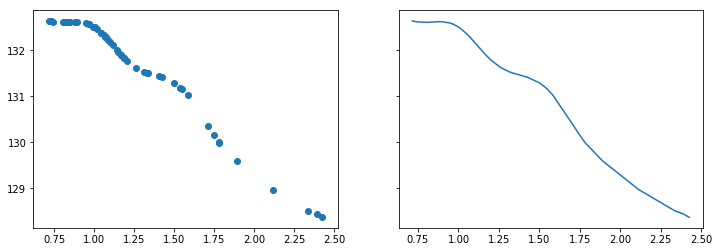

In [29]:
# TODO: Make this not as awful
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=[12,4])
ax[0].scatter(mass, Dnu)
ax[1].plot(mass, Dnu)

In [39]:
model_gp = pm.Model()
X = mass[:, None]

with model_gp:
    # now with a GP and some priors
    mean_func = pm.Normal('mean_func', 0, 1e2)
    cov_mass = pm.Normal('cov_mass', 0, 1e2)
    
    cov_func = pm.gp.cov.ExpQuad(1, ls = 0.05) # this is the squared exponential covariance function
    gp = pm.gp.Latent(cov_func=cov_func) # makes the mean function 0
    
    f = gp.prior('f', X=X) # produces some x drawn from the GP
    
    fit = pm.Deterministic('fit', mean_func*mass + cov_mass + f)
    
    # what we expect to see:
    obs = pm.Normal('obs', fit, observed=Dnu)
    
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, cov_mass, mean_func]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:24<00:00, 483.69draws/s]


In [40]:
pm.summary(trace, var_names=["mean_func", "cov_mass"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_func,-2.762,0.635,-3.954,-1.585,0.009,0.006,5512.0,5512.0,5509.0,5459.0,1.0
cov_mass,135.075,0.965,133.275,136.916,0.013,0.009,5465.0,5465.0,5461.0,5708.0,1.0


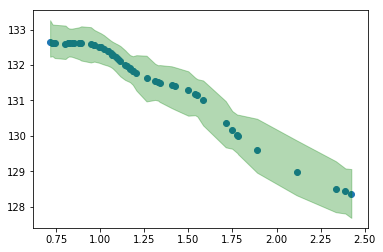

In [41]:
fig, ax = plt.subplots()
ax.scatter(mass, Dnu)

mean = np.mean(trace['fit'], axis=0)
std = np.std(trace['fit'], axis=0)

ax.fill_between(mass, mean-std, mean+std, alpha=0.3, color='g')

This seems okay? But not great either? It's pretty vague, even when there's information available - unless that's more to do with the scaling. It's also probably because I don't (shouldn't?) trust the data itself. As much as I like to see when the plots pinch in on the points, I really don't know that they're telling me the "truth" about the relationship between mass and observed $\Delta$$\nu$.

In [42]:
X_new = np.linspace(.75, 2.4, 50)[:, None]

with model_gp:
    f_new = gp.conditional('f_new', X_new)
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_new, fit], samples=1000)

/home/lindsey/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:14<00:00, 70.78it/s]


Text(0, 0.5, '$\\mathcal{GP}$ contribution')

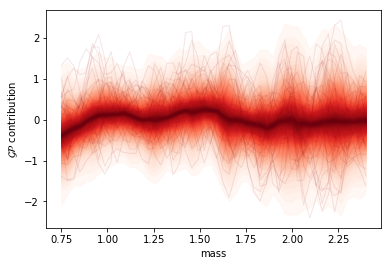

In [43]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots()
plot_gp_dist(ax, pred_samples['f_new'], X_new);
ax.set_xlabel('mass')
ax.set_ylabel(r'$\mathcal{GP}$ contribution')